# Cis Effects Template

NOTE: This notebook only looks at cis-effects for events on a single arm. If you're looking at different arm-level events on both arms of a chromosome, then make one copy of this template for the p arm, and another copy for the q arm.

This notebook compares the transcriptomics and proteomics correlations to CNV for cis proteins.

## Setup

In [1]:
import cnvutils
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy import stats
import seaborn as sns
import statsmodels.stats.multitest

In [2]:
# Load parameters
gen_params = cnvutils.load_params(os.path.join("..", "..", "..", "data", "gen_params.json"))
PANCAN = gen_params["PANCAN"]

chr_params = cnvutils.load_params(os.path.join("..", "..", "data", "chr_params.json"))
CHROMOSOME = chr_params["CHROMOSOME"]

arm_params = cnvutils.load_params(os.path.join("..", "data", "arm_params.json"))
ARM = arm_params["ARM"]
CANCER_TYPES = arm_params["ARM_CANCER_TYPES"]
EVENT_START = arm_params["START"]
EVENT_END = arm_params["END"]

# Set cis or trans
CIS_OR_TRANS = "cis"

# Get data tables
data_types = ["CNV", "proteomics", "transcriptomics"]
tables = cnvutils.load_tables(CANCER_TYPES, data_types, pancan=PANCAN)

cnv = tables["CNV"]
proteomics = tables["proteomics"]
transcriptomics = tables["transcriptomics"]

/home/caleb/anaconda3/envs/dev/lib/python3.9/site-packages/gtfparse/read_gtf.py:151: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  result = parse_gtf(
/home/caleb/anaconda3/envs/dev/lib/python3.9/site-packages/gtfparse/read_gtf.py:151: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  result = parse_gtf(


## Load all the data

In [3]:
# Get just the genes that are in our event
genes = cnvutils.get_event_genes(
    chrm=CHROMOSOME,
    event_start=EVENT_START,
    event_end=EVENT_END,
    cis_or_trans=CIS_OR_TRANS
)["Name"].\
drop_duplicates(keep="first")

## Run Pearson Tests

In [4]:
def run_pearsons(protein, cnv_df, omics):
    try:
        if protein in cnv_df.columns.get_level_values('Name'):
            cnv_data = cnv_df.loc[:,cnv_df.columns.get_level_values('Name')==protein]
            cnv_column_name = cnv_data.columns.tolist()[0]
        else:
            return (np.nan, np.nan)
        omics_data = omics[protein]
        if isinstance(omics_data, pd.DataFrame):
            omics_data = omics.iloc[:,0]
        omics_data.name = 'omics'
        df = pd.concat([cnv_data, omics_data], axis=1)
        df.dropna(inplace=True)
        if len(df) < 3:
            return (np.nan,np.nan)
        return stats.pearsonr(df[cnv_column_name], df['omics'])
    except Exception as e:
        print(e)

### Proteomics

In [5]:
proteomics_results = None
for cancer_type in proteomics.keys():
    try:
        # We will use the index from the proteomics table. 
        proteomics_table = proteomics[cancer_type].copy()
        proteomics_table = proteomics_table.loc[:, proteomics_table.columns.get_level_values('Name').isin(genes)]
        if isinstance(proteomics_table.columns, pd.MultiIndex):
            proteomics_table = proteomics_table.droplevel('Database_ID', axis=1)
        pvalues = list()
        rvalues = list()
        index = proteomics_table.columns.get_level_values('Name').tolist()
        for protein in index:
            r, p = run_pearsons(protein, cnv[cancer_type], proteomics_table)
            pvalues.append(p)
            rvalues.append(r)
        # Correct for multiple tests
        pvalues = np.array(pvalues)
        mask = np.isfinite(pvalues)
        pval_corrected = np.empty(len(pvalues))
        pval_corrected.fill(np.nan)
        pval_corrected[mask] = statsmodels.stats.multitest.multipletests(pvals=list(pvalues[mask]), alpha=0.05, method='fdr_bh')[1]
        temp = pd.DataFrame(data={f'{cancer_type}_pvalue_proteomics': pval_corrected, f'{cancer_type}_rvalue_proteomics': rvalues}, index=index)
        temp.index.name = 'Name'
        if proteomics_results is not None:
            proteomics_results = proteomics_results.join(temp, how='outer')
        else:
            proteomics_results = temp
    except Exception as e:
        print(e)

In [6]:
proteomics_results

,brca_pvalue_proteomics,brca_rvalue_proteomics,colon_pvalue_proteomics,colon_rvalue_proteomics,hnscc_pvalue_proteomics,hnscc_rvalue_proteomics,lscc_pvalue_proteomics,lscc_rvalue_proteomics,luad_pvalue_proteomics,luad_rvalue_proteomics,ovarian_pvalue_proteomics,ovarian_rvalue_proteomics
Name,,,,,,,,,,,,
ADAM28,9.987911e-01,0.001544,4.263492e-01,-0.710301,1.952939e-01,0.196317,4.372778e-06,0.451089,2.139517e-02,0.261458,8.921709e-01,0.040412
ADAMDEC1,6.354461e-01,0.067119,1.215875e-01,0.189699,6.683187e-01,0.085543,5.128415e-01,0.074245,6.466402e-02,0.215434,8.921709e-01,0.043949
AGPAT5,9.982535e-07,0.460113,1.564006e-06,0.494682,4.059021e-05,0.410667,1.323495e-07,0.507464,3.460971e-05,0.415707,1.104386e-07,0.583522
ANGPT2,9.939121e-01,0.014405,7.483747e-01,-0.063023,2.662306e-01,-0.161516,9.988007e-01,0.000145,7.332317e-02,0.198845,7.471989e-01,0.065227
ANGPT2,9.939121e-01,0.014405,7.483747e-01,-0.063023,2.662306e-01,-0.161516,9.988007e-01,0.000145,7.332317e-02,0.198845,7.471989e-01,0.065227
ARHGEF10,1.583294e-05,0.407578,9.370000e-02,0.240088,1.538617e-05,0.432019,7.886445e-05,0.389461,4.298127e-04,0.359039,1.023717e-05,0.506663
ASAH1,2.129855e-01,0.138400,2.269192e-03,0.334277,6.658151e-02,0.207967,7.017028e-04,0.336946,1.562066e-01,0.149607,3.230757e-03,0.356151
ATP6V1B2,5.732467e-06,0.427372,4.108169e-10,0.613026,3.198614e-03,0.308393,1.868973e-13,0.657365,9.320452e-05,0.394501,2.066515e-04,0.432693
BIN3,1.404069e-01,0.162063,5.927051e-02,0.222107,1.412483e-01,0.171451,1.184261e-01,0.165415,2.623522e-01,0.119814,1.265414e-02,0.307939


### Transcriptomics

In [7]:
transcriptomics_results = None
for cancer_type in transcriptomics.keys():
    try:
        # We will use the index from the proteomics table. 
        transcriptomics_table = transcriptomics[cancer_type].copy()
        transcriptomics_table = transcriptomics_table.loc[:, transcriptomics_table.columns.get_level_values('Name').isin(genes)]
        if isinstance(transcriptomics_table.columns, pd.MultiIndex):
            transcriptomics_table = transcriptomics_table.droplevel('Database_ID', axis=1)
        pvalues = list()
        rvalues = list()
        index = transcriptomics_table.columns.get_level_values('Name').tolist()
        for protein in index:
            r, p = run_pearsons(protein, cnv[cancer_type], transcriptomics_table)
            pvalues.append(p)
            rvalues.append(r)
        pvalues = np.array(pvalues)
        mask = np.isfinite(pvalues)
        pval_corrected = np.empty(len(pvalues))
        pval_corrected.fill(np.nan)
        pval_corrected[mask] = statsmodels.stats.multitest.multipletests(pvals=list(pvalues[mask]), alpha=0.05, method='fdr_bh')[1]
        temp = pd.DataFrame(data={f'{cancer_type}_pvalue_transcriptomics': pval_corrected, f'{cancer_type}_rvalue_transcriptomics': rvalues}, index=index)
        temp.index.name = 'Name'
        if transcriptomics_results is not None:
            transcriptomics_results = transcriptomics_results.join(temp, how='outer')
        else:
            transcriptomics_results = temp
    except Exception as e:
        print(e)

/home/caleb/anaconda3/envs/dev/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [8]:
transcriptomics_results

,brca_pvalue_transcriptomics,brca_rvalue_transcriptomics,colon_pvalue_transcriptomics,colon_rvalue_transcriptomics,hnscc_pvalue_transcriptomics,hnscc_rvalue_transcriptomics,lscc_pvalue_transcriptomics,lscc_rvalue_transcriptomics,luad_pvalue_transcriptomics,luad_rvalue_transcriptomics,ovarian_pvalue_transcriptomics,ovarian_rvalue_transcriptomics
Name,,,,,,,,,,,,
AC004944.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AC007718.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AC008066.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AC009314.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AC009435.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AC009563.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AC009623.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AC009623.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AC009623.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Create Graphs

In [9]:
# Join the graphs
all_results = transcriptomics_results.join(proteomics_results)

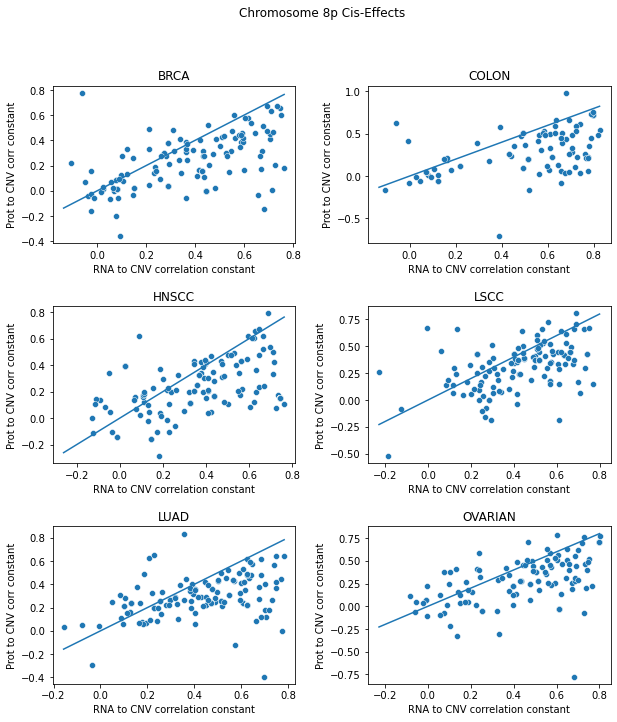

In [10]:
fig, axs = plt.subplots(nrows=3, ncols=2, sharex=False, sharey=False, figsize=(10,11))
fig.suptitle("Chromosome 8p Cis-Effects")
count = 0
for cancer_type in proteomics.keys():
    sns.scatterplot(x=f'{cancer_type}_rvalue_transcriptomics', y=f'{cancer_type}_rvalue_proteomics', data=all_results, ax=axs[count//2][count%2])
    axs[count//2][count%2].set_title(cancer_type.upper())
    axs[count//2][count%2].set_xlabel("RNA to CNV correlation constant")
    axs[count//2][count%2].set_ylabel("Prot to CNV corr constant")
    min_val = np.min(all_results[f'{cancer_type}_rvalue_transcriptomics'])
    max_val = np.max(all_results[f'{cancer_type}_rvalue_transcriptomics'])
    axs[count//2][count%2].plot([min_val,max_val], [min_val,max_val])
    count += 1
plt.subplots_adjust(hspace=0.4, wspace=0.3)

In [11]:
# Save the chart
chart_fmt = gen_params["CHART_FORMAT"]
chart_dpi = gen_params["CHART_DPI"]

chart_dir = os.path.join("..", "data", "charts_img")
chart_path = os.path.join(
    chart_dir,
    f"chr{CHROMOSOME}{ARM}_{CIS_OR_TRANS}_00_pearson_{'harmonized' if PANCAN else 'AWG'}_matplotlib.{chart_fmt}"
)

fig.savefig(chart_path, dpi=chart_dpi)

## Reformat results and save

In [12]:
all_results = transcriptomics_results.join(proteomics_results).reset_index(drop=False)
all_results = all_results.melt(id_vars=['Name'])
all_results[['cancer', 'type', 'omics']] = all_results.variable.str.split('_', expand=True)
all_results.dropna(inplace=True)

table_path = os.path.join(
    "..",
    "data",
    f"chr{CHROMOSOME}{ARM}_{CIS_OR_TRANS}_00_pearson_{'harmonized' if PANCAN else 'AWG'}.tsv"
)
all_results.to_csv(table_path, sep="\t", index=False)